In [1]:
import os
import pandas as pd
from tqdm import tqdm
from nltk import word_tokenize
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
import re
import seaborn as sns
import matplotlib.pyplot as plt
from collections import  Counter
import numpy as np
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.stem import PorterStemmer
from spacy.lang.en import English
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     /home/users/azgrzebn/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
os.getcwd()

'/home/users/azgrzebn/TM_in_python_PW-main'

In [3]:
data = pd.read_csv("fake_job_postings.csv", sep = ",")

In [4]:
data.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [6]:
print(data.columns)
data.describe()

Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')


,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
columns=['job_id', 'telecommuting', 'has_company_logo', 'has_questions', 'salary_range', 'employment_type', 'location']
for col in columns:
    del data[col]

data.fillna(' ', inplace=True)

In [8]:
data.head()

,title,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,Internship,,,Marketing,0
1,Customer Service - Cloud Video Production,Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Not Applicable,,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,,,,,0
3,Account Executive - Washington DC,Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,Bill Review Manager,,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


,fraudulent,title
0,0,17014
1,1,866


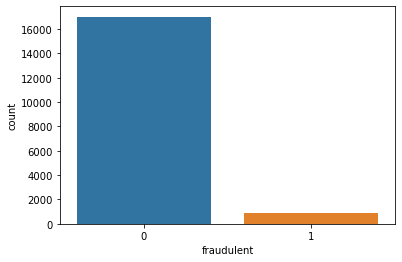

In [9]:
sns.countplot(data.fraudulent)
data.groupby('fraudulent').count()['title'].reset_index().sort_values(by='title',ascending=False)

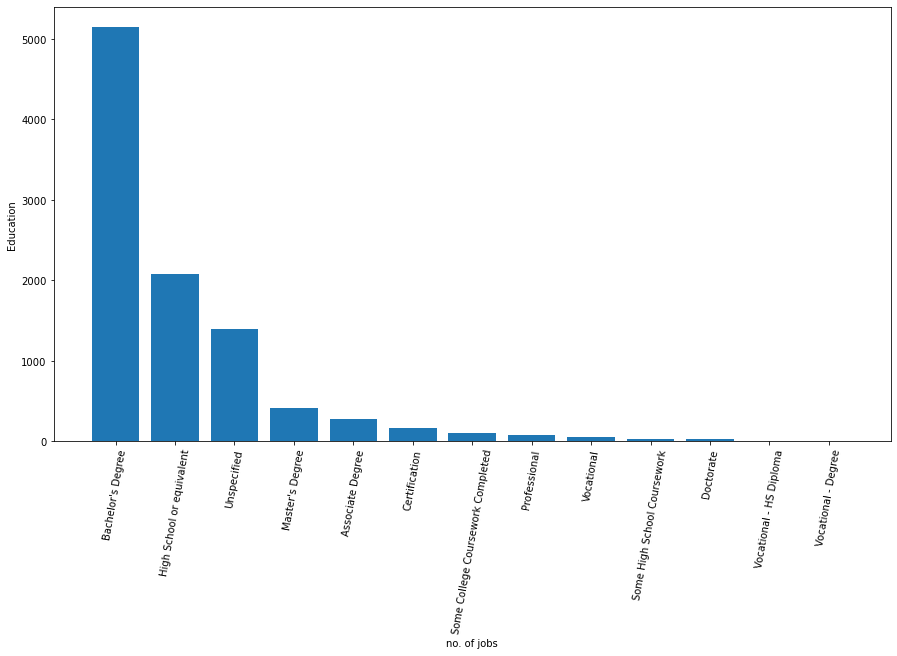

In [10]:
education = dict(data.required_education.value_counts())
del education[' ']
plt.figure(figsize=(15, 8))
plt.bar(education.keys(), education.values())
plt.xlabel('no. of jobs', size=10)
plt.ylabel('Education')
plt.xticks(rotation=80)
plt.show()

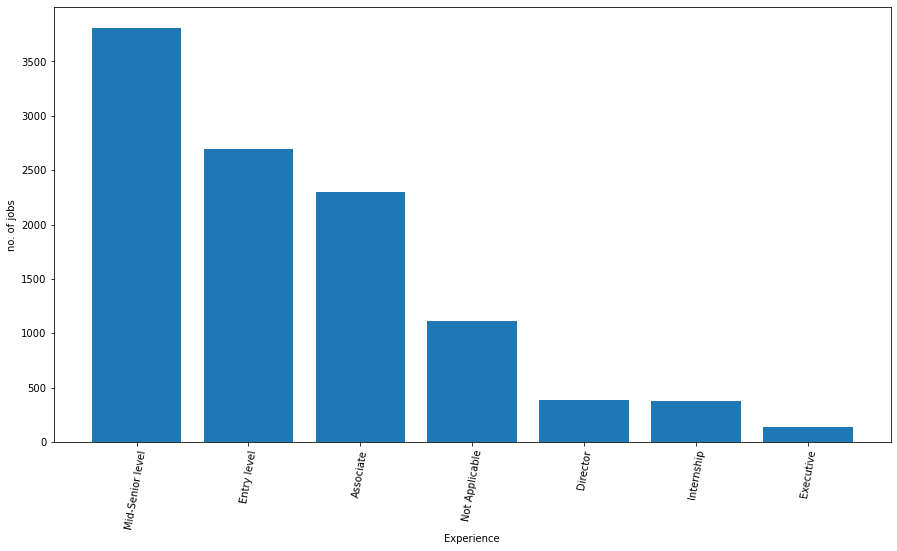

In [11]:
experience = dict(data.required_experience.value_counts())
del experience[' ']
plt.figure(figsize=(15, 8))
plt.bar(experience.keys(), experience.values())
plt.xlabel('Experience', size=10)
plt.ylabel('no. of jobs', size=10)
plt.xticks(rotation=80)
plt.show()

In [12]:
print(data.title.value_counts()[:10])

English Teacher Abroad                                311
Customer Service Associate                            146
Graduates: English Teacher Abroad (Conversational)    144
English Teacher Abroad                                 95
Software Engineer                                      86
English Teacher Abroad (Conversational)                83
Customer Service Associate - Part Time                 76
Account Manager                                        75
Web Developer                                          66
Project Manager                                        62
Name: title, dtype: int64


In [13]:
print(data.department.value_counts()[:10])

                          11553
Sales                       551
Engineering                 487
Marketing                   401
Operations                  270
IT                          225
Development                 146
Product                     112
Information Technology       86
Technology                   76
Name: department, dtype: int64


In [14]:
print(data.industry.value_counts()[:10])

                                       4903
Information Technology and Services    1734
Computer Software                      1376
Internet                               1062
Marketing and Advertising               828
Education Management                    822
Financial Services                      779
Hospital & Health Care                  497
Consumer Services                       358
Telecommunications                      342
Name: industry, dtype: int64


In [15]:
print(data.function.value_counts()[:10])

                          6455
Information Technology    1749
Sales                     1468
Engineering               1348
Customer Service          1229
Marketing                  830
Administrative             630
Design                     340
Health Care Provider       338
Other                      325
Name: function, dtype: int64


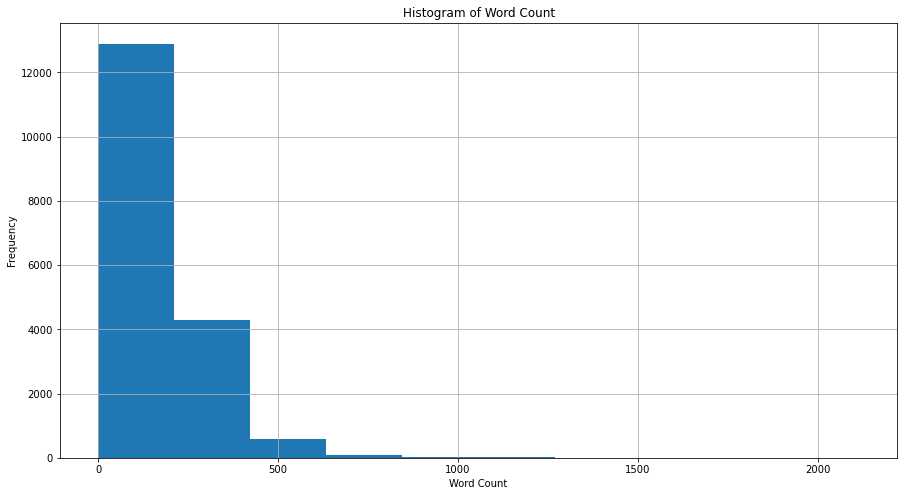

count    17880.000000
mean       170.445973
std        123.304236
min          0.000000
25%         87.000000
50%        146.000000
75%        224.000000
max       2115.000000
Name: description, dtype: float64

In [16]:
word_count = data['description'].str.split().map(lambda x: len(x))
plt.figure(figsize=(15, 8))
word_count.hist()
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Histogram of Word Count')
plt.show()
word_count.describe()

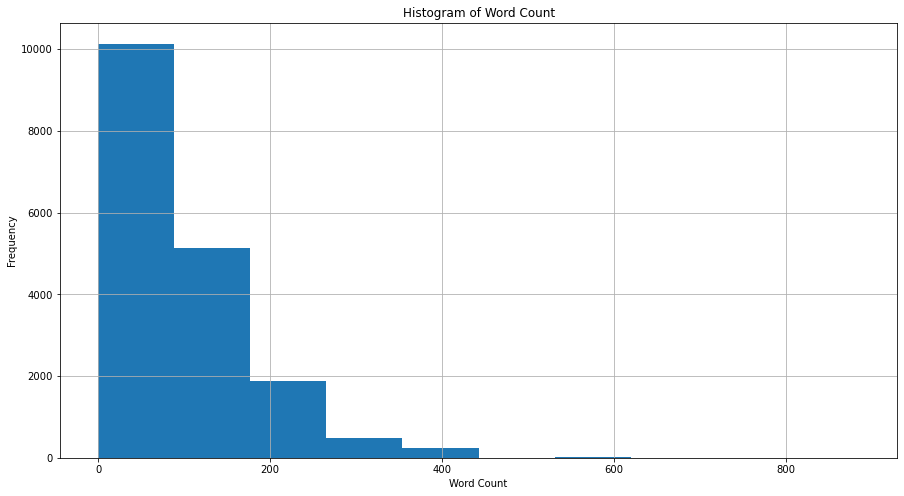

count    17880.000000
mean        92.553579
std         85.487278
min          0.000000
25%         21.000000
50%         83.000000
75%        132.000000
max        885.000000
Name: company_profile, dtype: float64

In [17]:
word_count = data['company_profile'].str.split().map(lambda x: len(x))
plt.figure(figsize=(15, 8))
word_count.hist()
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Histogram of Word Count')
plt.show()
word_count.describe()

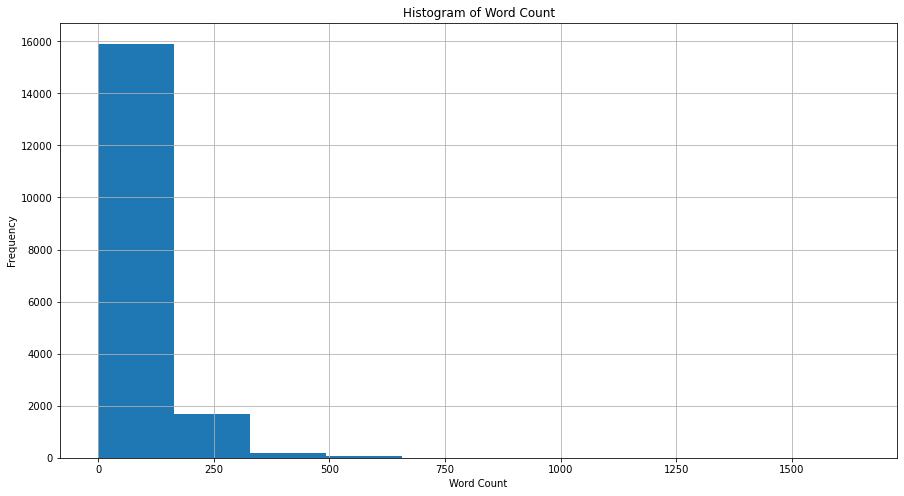

count    17880.000000
mean        78.032998
std         81.652903
min          0.000000
25%         19.000000
50%         62.000000
75%        108.000000
max       1645.000000
Name: requirements, dtype: float64

In [18]:
word_count = data['requirements'].str.split().map(lambda x: len(x))
plt.figure(figsize=(15, 8))
word_count.hist()
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Histogram of Word Count')
plt.show()
word_count.describe()

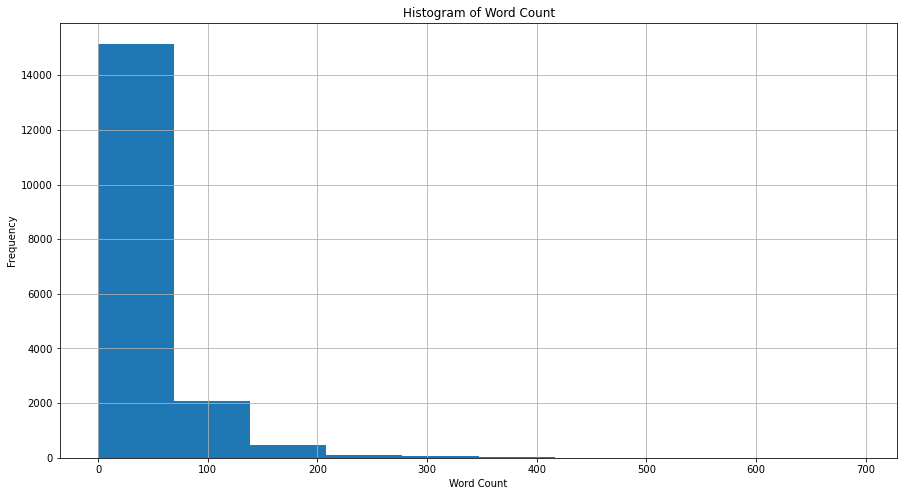

count    17880.000000
mean        29.990996
std         49.755724
min          0.000000
25%          0.000000
50%          6.000000
75%         41.000000
max        694.000000
Name: benefits, dtype: float64

In [19]:
word_count = data['benefits'].str.split().map(lambda x: len(x))
plt.figure(figsize=(15, 8))
word_count.hist()
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Histogram of Word Count')
plt.show()
word_count.describe()

In [20]:
data2 = data.loc[data['fraudulent'] == 1]

In [21]:
data2.head()

,title,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent
98,IC&E Technician,Oil & Energy,...,"IC&amp;E Technician | Bakersfield, CA Mt. Poso...","QualificationsKnowledge, Skills &amp; Abilitie...",BENEFITSWhat is offered:Competitive compensati...,Mid-Senior level,High School or equivalent,Oil & Energy,Other,1
144,Forward Cap.,,,The group has raised a fund for the purchase o...,,,,,,,1
173,Technician Instrument & Controls,Power Plant & Energy,Edison International and Refined Resources hav...,Technician Instrument &amp; ControlsLocation D...,JOB QUALIFICATIONS-Ability to understand proce...,"we are a team of almost 8,000 employees who he...",Mid-Senior level,Certification,Electrical/Electronic Manufacturing,Other,1
180,Sales Executive,Sales,,Sales Executive,Sales Executive,Sales Executive,,,,Sales,1
215,IC&E Technician Mt Poso,Oil & Energy,...,"IC&amp;E Technician | Bakersfield, CA Mt. Poso...","QualificationsKnowledge, Skills &amp; Abiliti...",BENEFITSWhat is offered:Competitive compensati...,Mid-Senior level,High School or equivalent,Oil & Energy,Other,1


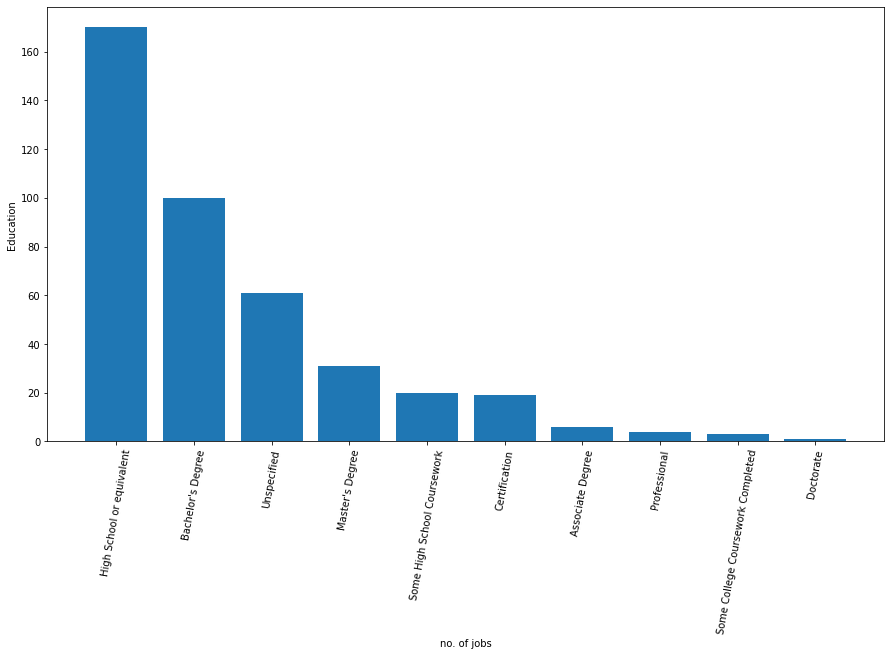

In [22]:
education = dict(data2.required_education.value_counts())
del education[' ']
plt.figure(figsize=(15, 8))
plt.bar(education.keys(), education.values())
plt.xlabel('no. of jobs', size=10)
plt.ylabel('Education')
plt.xticks(rotation=80)
plt.show()

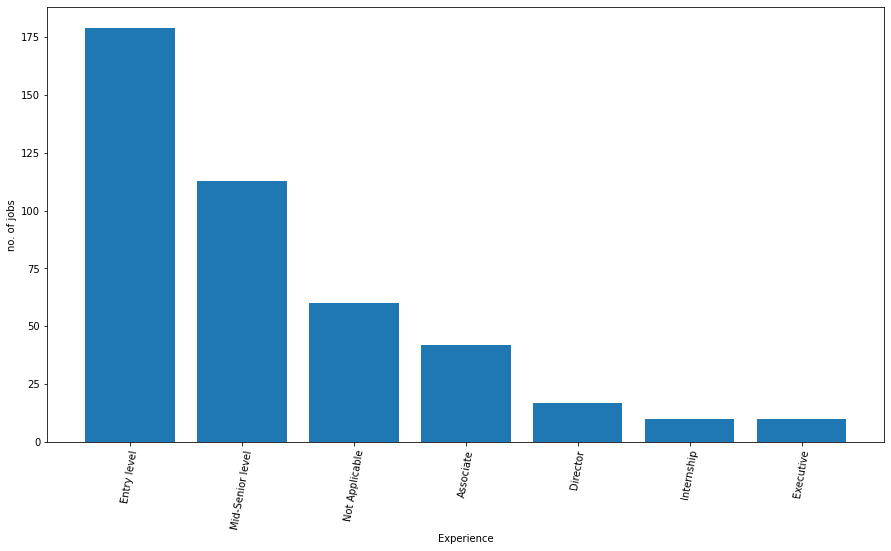

In [23]:
experience = dict(data2.required_experience.value_counts())
del experience[' ']
plt.figure(figsize=(15, 8))
plt.bar(experience.keys(), experience.values())
plt.xlabel('Experience', size=10)
plt.ylabel('no. of jobs', size=10)
plt.xticks(rotation=80)
plt.show()

In [24]:
print(data2.title.value_counts()[:10])

Data Entry Admin/Clerical Positions - Work From Home                    21
Home Based Payroll Typist/Data Entry Clerks Positions Available         21
Cruise Staff Wanted *URGENT*                                            21
Customer Service Representative                                         17
Administrative Assistant                                                16
Home Based Payroll Data Entry Clerk Position - Earn $100-$200 Daily     12
Network Marketing                                                       10
Payroll Data Coordinator Positions - Earn $100-$200 Daily               10
Payroll Clerk                                                           10
Account Sales Managers $80-$130,000/yr                                  10
Name: title, dtype: int64


In [25]:
print(data2.department.value_counts()[:10])

                           531
Engineering                 46
Clerical                    27
Oil & Energy                24
Information Technology      15
Administrative              14
Customer Service            14
Sales                       12
Information Technology      12
Engineering                  9
Name: department, dtype: int64


In [26]:
print(data2.industry.value_counts()[:10])

                                       275
Oil & Energy                           109
Accounting                              57
Hospital & Health Care                  51
Marketing and Advertising               45
Financial Services                      35
Information Technology and Services     32
Telecommunications                      26
Consumer Services                       24
Real Estate                             24
Name: industry, dtype: int64


In [27]:
print(data2.function.value_counts()[:10])

                          337
Administrative            119
Engineering               113
Customer Service           67
Sales                      41
Information Technology     32
Other                      32
Accounting/Auditing        29
Finance                    15
Business Development       13
Name: function, dtype: int64


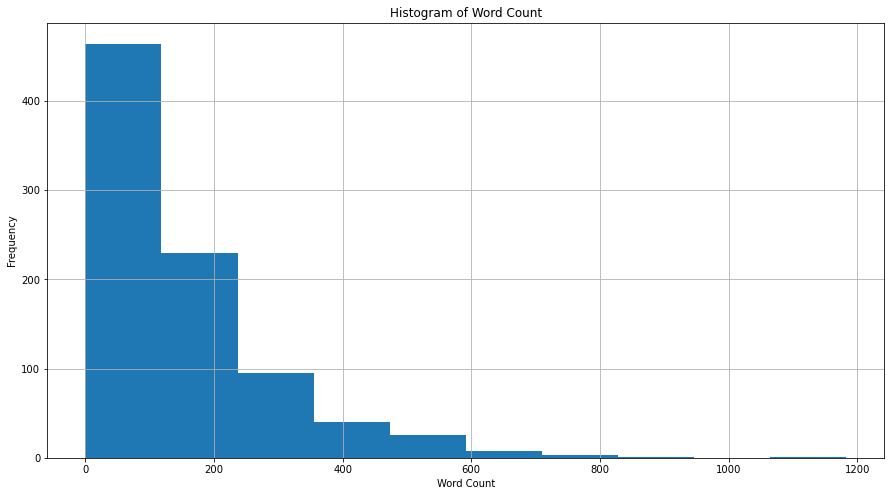

count     866.000000
mean      158.748268
std       136.633010
min         0.000000
25%        67.000000
50%       113.500000
75%       213.000000
max      1183.000000
Name: description, dtype: float64

In [28]:
word_count = data2['description'].str.split().map(lambda x: len(x))
plt.figure(figsize=(15, 8))
word_count.hist()
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Histogram of Word Count')
plt.show()
word_count.describe()

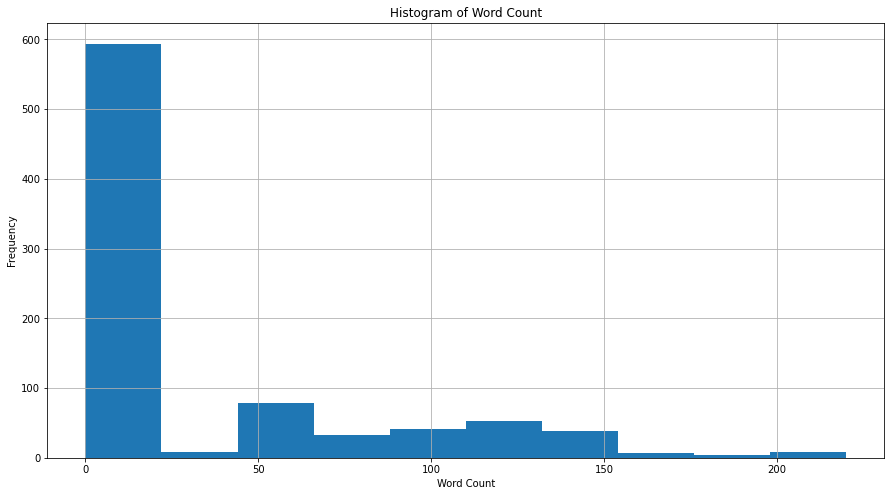

count    866.000000
mean      31.709007
std       52.468109
min        0.000000
25%        0.000000
50%        0.000000
75%       56.000000
max      220.000000
Name: company_profile, dtype: float64

In [29]:
word_count = data2['company_profile'].str.split().map(lambda x: len(x))
plt.figure(figsize=(15, 8))
word_count.hist()
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Histogram of Word Count')
plt.show()
word_count.describe()

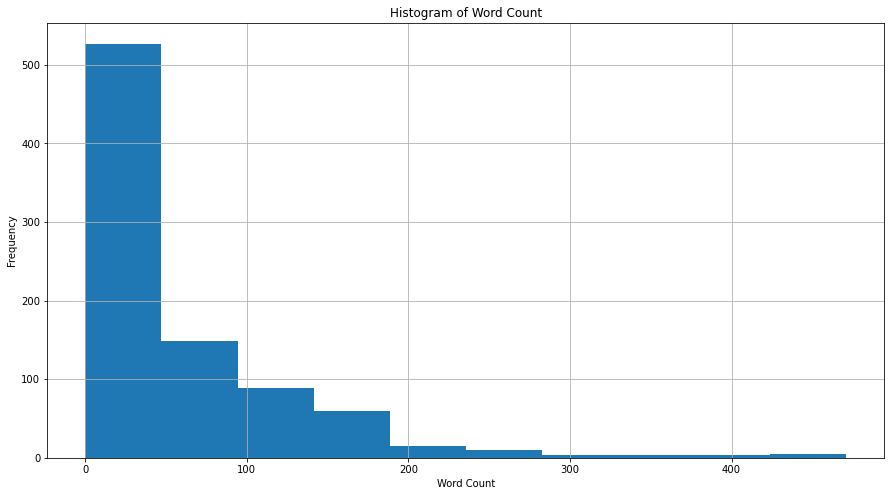

count    866.000000
mean      58.407621
std       73.356609
min        0.000000
25%        7.000000
50%       34.000000
75%       84.000000
max      471.000000
Name: requirements, dtype: float64

In [30]:
word_count = data2['requirements'].str.split().map(lambda x: len(x))
plt.figure(figsize=(15, 8))
word_count.hist()
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Histogram of Word Count')
plt.show()
word_count.describe()

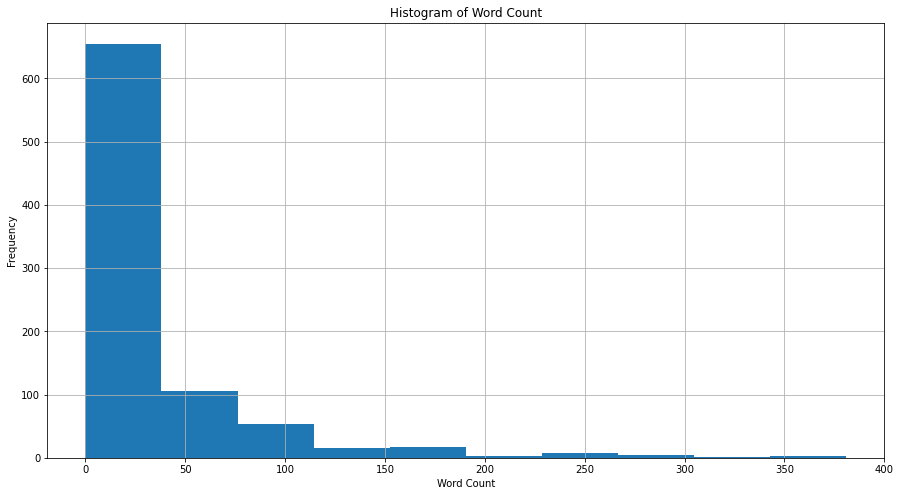

count    866.000000
mean      29.451501
std       53.444374
min        0.000000
25%        0.000000
50%        5.000000
75%       37.000000
max      381.000000
Name: benefits, dtype: float64

In [31]:
word_count = data2['benefits'].str.split().map(lambda x: len(x))
plt.figure(figsize=(15, 8))
word_count.hist()
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Histogram of Word Count')
plt.show()
word_count.describe()

In [32]:
data['text']=data['title']+' '+' '+data['company_profile']+' '+data['description']+' '+data['requirements']+' '+data['benefits']

In [33]:
data.text[0]

"Marketing Intern  We're Food52, and we've created a groundbreaking and award-winning cooking site. We support, connect, and celebrate home cooks, and give them everything they need in one place.We have a top editorial, business, and engineering team. We're focused on using technology to find new and better ways to connect people around their specific food interests, and to offer them superb, highly curated information about food and cooking. We attract the most talented home cooks and contributors in the country; we also publish well-known professionals like Mario Batali, Gwyneth Paltrow, and Danny Meyer. And we have partnerships with Whole Foods Market and Random House.Food52 has been named the best food website by the James Beard Foundation and IACP, and has been featured in the New York Times, NPR, Pando Daily, TechCrunch, and on the Today Show.We're located in Chelsea, in New York City. Food52, a fast-growing, James Beard Award-winning online food community and crowd-sourced and c

In [34]:
data.head()

,title,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent,text
0,Marketing Intern,Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,Internship,,,Marketing,0,"Marketing Intern We're Food52, and we've crea..."
1,Customer Service - Cloud Video Production,Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Not Applicable,,Marketing and Advertising,Customer Service,0,Customer Service - Cloud Video Production 90 ...
2,Commissioning Machinery Assistant (CMA),,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,,,,,0,Commissioning Machinery Assistant (CMA) Valor...
3,Account Executive - Washington DC,Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,Account Executive - Washington DC Our passion...
4,Bill Review Manager,,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,Bill Review Manager SpotSource Solutions LLC ...


In [35]:
columns=['title', 'department', 'company_profile', 'description', 'requirements', 'benefits', 'required_experience', 'required_education', 'industry', 'function']
for col in columns:
    del data[col]
    
data.fillna(' ', inplace=True)

In [36]:
data.head()

,fraudulent,text
0,0,"Marketing Intern We're Food52, and we've crea..."
1,0,Customer Service - Cloud Video Production 90 ...
2,0,Commissioning Machinery Assistant (CMA) Valor...
3,0,Account Executive - Washington DC Our passion...
4,0,Bill Review Manager SpotSource Solutions LLC ...


In [37]:
data.head()

,fraudulent,text
0,0,"Marketing Intern We're Food52, and we've crea..."
1,0,Customer Service - Cloud Video Production 90 ...
2,0,Commissioning Machinery Assistant (CMA) Valor...
3,0,Account Executive - Washington DC Our passion...
4,0,Bill Review Manager SpotSource Solutions LLC ...


In [38]:
corpus = []
for x in data['text'].str.split():
    corpus.extend(x)

In [39]:
counter=Counter(corpus)
most=counter.most_common()

In [40]:
stop=set(stopwords.words('english'))

In [41]:
most_nostop = []
for word, count in most:
    if word.lower() not in stop:
        most_nostop.append((word, count))

20 najczęściej występujących slów w korpusie


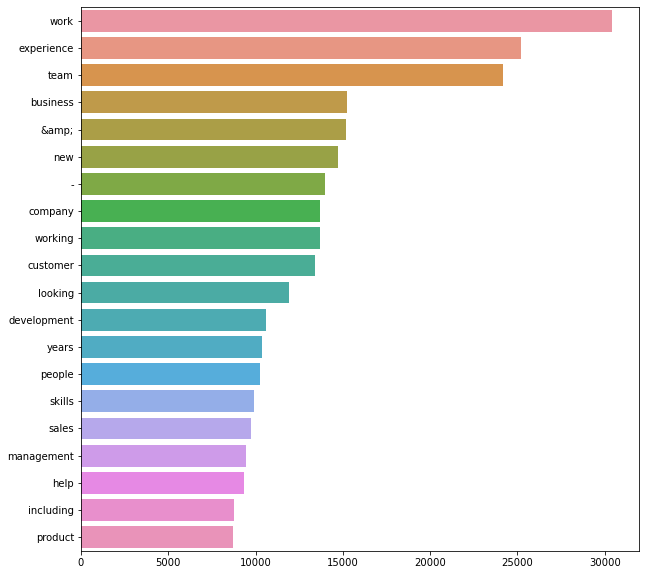

In [42]:
first_n = 20
x, y= [], []
for word,count in most_nostop[:first_n]:
        x.append(word)
        y.append(count)

plt.figure(figsize=(10, 10))
sns.barplot(x=y,y=x)
print(f"{first_n} najczęściej występujących slów w korpusie")

In [43]:
def clean(text):
    text=text.lower()
    obj=re.compile(r"<.*?>")                     #removing html tags
    text=obj.sub(r" ",text)
    obj=re.compile(r"https://\S+|http://\S+")    #removing url
    text=obj.sub(r" ",text)
    obj=re.compile(r"[^\w\s]")                   #removing punctuations
    text=obj.sub(r" ",text)
    obj=re.compile(r"\d{1,}")                    #removing digits
    text=obj.sub(r" ",text)
    obj=re.compile(r"_+")                        #removing underscore
    text=obj.sub(r" ",text)
    obj=re.compile(r"\s\w\s")                    #removing single character
    text=obj.sub(r" ",text)
    obj=re.compile(r"\s{2,}")                    #removing multiple spaces
    text=obj.sub(r" ",text)
   
    
    stemmer = PorterStemmer()
    text=[stemmer.stem(word) for word in text.split() if word not in stop]
    
    return " ".join(text)

In [44]:
tqdm.pandas()
data['text']=data["text"].progress_apply(clean)

100%|██████████| 17880/17880 [01:14<00:00, 239.87it/s]


In [45]:
data.head()

,fraudulent,text
0,0,market intern food creat groundbreak award win...
1,0,custom servic cloud video product second world...
2,0,commiss machineri assist cma valor servic prov...
3,0,account execut washington dc passion improv qu...
4,0,bill review manag spotsourc solut llc global h...


In [46]:
fraudjobs_text = data[data.fraudulent==1].text
actualjobs_text = data[data.fraudulent==0].text

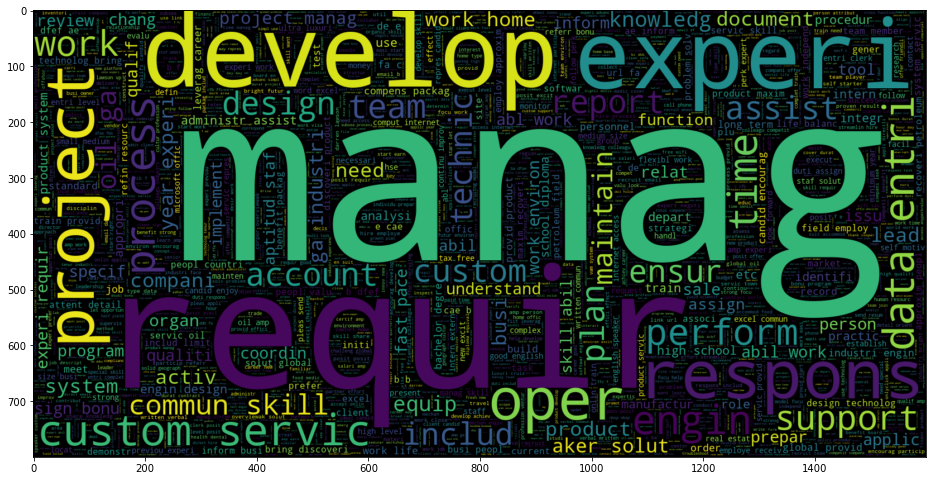

In [47]:
#fałszywe
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(str(" ".join(fraudjobs_text)))
plt.imshow(wc,interpolation = 'bilinear')

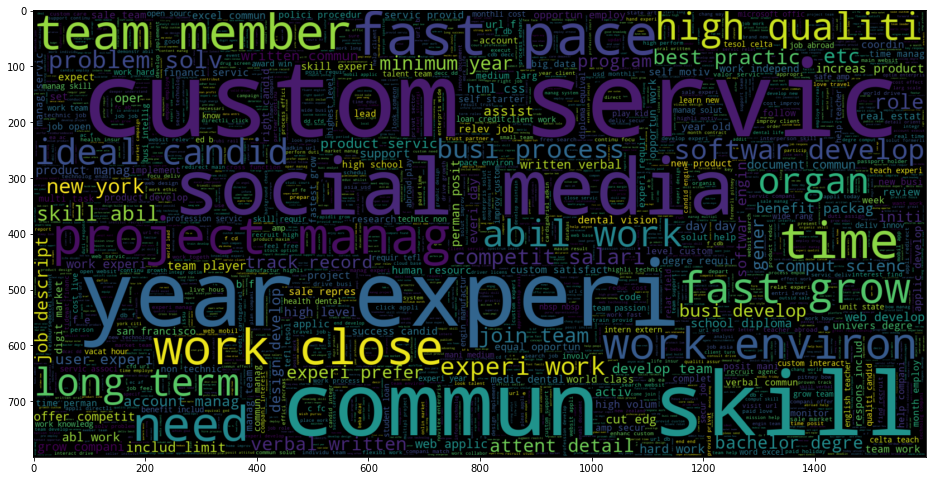

In [48]:
#prawdziwe
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(str(" ".join(actualjobs_text)))
plt.imshow(wc,interpolation = 'bilinear')

In [58]:
X_data = data["text"].copy()
y_data = data["fraudulent"].copy()
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3,random_state=random_state )

In [60]:
x_train_df = X_train

In [61]:
x_test_df = X_test

In [62]:
x_test_df.count()

5364

In [63]:
y_train.count()

12516

In [64]:
y_train.value_counts(normalize=True)

0    0.952461
1    0.047539
Name: fraudulent, dtype: float64

In [65]:
y_test.count()

5364

In [66]:
y_test.value_counts(normalize=True)

0    0.949478
1    0.050522
Name: fraudulent, dtype: float64

In [67]:
def getScores(estimator, x, y):
    yPred = estimator.predict(x)
    return (metrics.accuracy_score(y, yPred), 
            metrics.f1_score(y, yPred, average='micro'), 
            metrics.f1_score(y, yPred, average='macro'))

def my_scorer(estimator, x, y):
    a, p, r = getScores(estimator, x, y)
    print("Accuracy: {} | F1 micro: {} | F1 macro: {}".format(a, p, r))
    return a+p+r

In [68]:
clf = SGDClassifier(loss='hinge', penalty='l2', learning_rate='optimal', alpha=1e-4, random_state=42, class_weight='balanced')
pipe = Pipeline([('tfidf', TfidfVectorizer()),
                ('clf', clf),
               ])

In [69]:
x_train = x_train_df
scores = cross_val_score(pipe, x_train, np.ravel(y_train), scoring=my_scorer, cv=10)

Accuracy: 0.9808306709265175 | F1 micro: 0.9808306709265175 | F1 macro: 0.8981837896448903
Accuracy: 0.9808306709265175 | F1 micro: 0.9808306709265175 | F1 macro: 0.8915265985097902
Accuracy: 0.9840255591054313 | F1 micro: 0.9840255591054313 | F1 macro: 0.9138346340724834
Accuracy: 0.9808306709265175 | F1 micro: 0.9808306709265175 | F1 macro: 0.8997156474027795
Accuracy: 0.9824281150159745 | F1 micro: 0.9824281150159745 | F1 macro: 0.9037192393736018
Accuracy: 0.9792332268370607 | F1 micro: 0.9792332268370607 | F1 macro: 0.8913586180196778
Accuracy: 0.9872102318145484 | F1 micro: 0.9872102318145484 | F1 macro: 0.9276815908893835
Accuracy: 0.9768185451638689 | F1 micro: 0.9768185451638689 | F1 macro: 0.8558555337028428
Accuracy: 0.9832134292565947 | F1 micro: 0.9832134292565947 | F1 macro: 0.9129017820140903
Accuracy: 0.9848121502797762 | F1 micro: 0.9848121502797762 | F1 macro: 0.9134114132711608


In [70]:
pipe.fit(x_train, y_train.values.ravel())

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf',
                 SGDClassifier(class_weight='balanced', random_state=42))])

In [72]:
y_pred = pipe.predict(x_test_df)

In [73]:
print("SGD Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("SGD F1 micro:",metrics.f1_score(y_test, y_pred, average='micro'))
print("SGD F1 macro:",metrics.f1_score(y_test, y_pred, average='macro'))

SGD Accuracy: 0.982289336316182
SGD F1 micro: 0.982289336316182
SGD F1 macro: 0.9068846484657018


In [74]:
print(classification_report(y_test, y_pred, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5093
           1       0.83      0.82      0.82       271

    accuracy                           0.98      5364
   macro avg       0.91      0.90      0.91      5364
weighted avg       0.98      0.98      0.98      5364



In [75]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(x_train, y_train)
y_pred = dummy_clf.predict(x_test_df)
print("Dummy classifier Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Dummy classifier F1 micro:",metrics.f1_score(y_test, y_pred, average='micro'))
print("Dummy classifier F1 macro:",metrics.f1_score(y_test, y_pred, average='macro'))

Dummy classifier Accuracy: 0.9494780014914244
Dummy classifier F1 micro: 0.9494780014914244
Dummy classifier F1 macro: 0.48704217270727745


In [76]:
print(classification_report(y_test, y_pred, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      5093
           1       0.00      0.00      0.00       271

    accuracy                           0.95      5364
   macro avg       0.47      0.50      0.49      5364
weighted avg       0.90      0.95      0.92      5364



/home/users/azgrzebn/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/users/azgrzebn/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/users/azgrzebn/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
